In [ ]:
# import attention
from attention import AttentionLayer

In [1]:
import pandas as pd
import numpy as np
import re
import time
from nltk.corpus import stopwords

In [2]:
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from bs4 import BeautifulSoup 
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.1.0


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lkw06\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [5]:
news_summary = pd.read_csv("news_summary_more.csv",encoding='ISO-8859-1')
news_summary.shape

(98401, 2)

# Data Preprocessing

In [6]:
print('Story: ' + str(news_summary['Full Stories'][1]))
print('Summaries: ' + str(news_summary['Summary'][1]))
news_summary.head()

Story: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summaries: Delhi techie wins free food from Swiggy for one year on CRED


,Summary,Full Stories
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."


In [7]:
news_summary.dropna(axis=0,inplace=True)
news_summary.shape

(98401, 2)

In [8]:
news_summary.drop_duplicates(subset=['Full Stories'],inplace=True)  #dropping duplicates
news_summary.shape

(98360, 2)

In [9]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR"}

CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

In [10]:
#English Contraction
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [11]:
def clean_text(text, remove_stopwords = True):
#     text = text.replace('(CNN) -- ', '')
    text = text.lower()
#     text = BeautifulSoup(text, "lxml").text
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    #Remove website url
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #Remove Email
    text = EMAIL_REGEX.sub('',text)
    #Remove currency symbol
    text = CURRENCY_REGEX.sub('',text)
    #Convert short forms to full text
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    #Remove Special Characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    #Remove number from string
    text = re.sub(r'[0-9]', "", text) 
    #Remove 's and backspace
    text = re.sub(r"'s\b","", text)
    #Remove ampersand
    text = re.sub(r'&amp;', '', text)
    #Remove newline
    text = re.sub('\n', ' ', text)
    # Remove multiple spaces
    text = re.sub("(\s+)", " ", str(text)).lower()
    # Remove the single character hanging between any two spaces
    text = re.sub("(\s+.\s+)", " ", str(text)).lower()
    
    # Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(text)
    
    # Lemmatize list of words and join
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    

    return text

In [12]:
cleaned_full_text = []
cleaned_summary = []
for fullText in news_summary['Full Stories']:
    cleaned_full_text.append(clean_text(fullText, remove_stopwords=True))
print("Full Text are complete.")

for summary in news_summary['Summary']:    
    cleaned_summary.append(clean_text(summary, remove_stopwords=True))
print("Summary are complete.")

Full Text are complete.
Summary are complete.


# Data Understanding

In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, cleaned_summary)
count_words(word_counts, cleaned_full_text)
            
print("Size of Vocabulary for both text and summary:", len(word_counts))

In [ ]:
embeddings_index = {}
with open(r'C:\Users\lkw06\Desktop\numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Word embeddings:', len(embeddings_index))

In [ ]:
# Find the number of words that are missing from the word embeddings, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from Word Embeddings:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

In [ ]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1
# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

In [ ]:
embedding_dim = 300
nb_words = len(vocab_to_int)
word_embedding_matrix = np.zeros((nb_words, embedding_dim), 
                                 dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
print(len(word_embedding_matrix))

In [ ]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                #UNK Means the the word didn't exist in the word embeddings
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [ ]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(cleaned_summary, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(cleaned_full_text, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in Story and Summary:", word_count)
print("Total number of UNKs in Story and Summary:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

In [ ]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

In [ ]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [13]:
news_summary['cleaned_text']=cleaned_full_text
news_summary['cleaned_summary']=cleaned_summary
news_summary['cleaned_text'] = news_summary['cleaned_text'].str.findall('\w{2,}').str.join(' ')
news_summary['cleaned_summary'] = news_summary['cleaned_summary'].str.findall('\w{2,}').str.join(' ')
news_summary['cleaned_summary'] = news_summary['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [14]:
print('Story: ' + str(news_summary['cleaned_text'][1]))
print('Summaries: ' + str(news_summary['cleaned_summary'][1]))

Story: kunal shah credit card bill payment platform cred gave user chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coin user get one cred coin per rupee bill paid used avail reward brand like ixigo bookmyshow ubereats cultfit
Summaries: sostok delhi techie win free food swiggy one year cred eostok


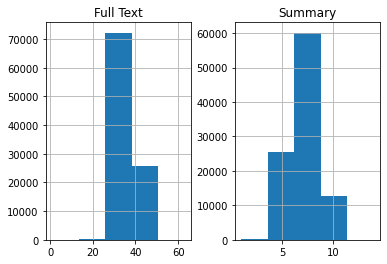

In [15]:
import matplotlib.pyplot as plt #pip install matplotlib

text_word_count = []
summary_word_count = []

for i in cleaned_full_text:
    text_word_count.append(len(i.split()))
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Full Text': text_word_count, 'Summary': summary_word_count})
length_df.hist(bins=5)
plt.show()

In [16]:
count = 0
for i in cleaned_full_text:
    if(len(i.split()) <= 50):
        count += 1
print(count/len(cleaned_full_text))

count = 0
for i in cleaned_summary:
    if(len(i.split())<=10):
        count += 1
print(count/len(cleaned_summary))

0.9997356649044327
0.9961163074420496


In [19]:
max_text_len = 50
max_summary_length = 10

cleaned_full_text = np.array(news_summary['cleaned_text'])
cleaned_summary = np.array(news_summary['cleaned_summary'])

short_full_text = []
short_summary = []

for i in range(len(cleaned_full_text)):
    if(len(cleaned_summary[i].split())<=max_summary_length and len(cleaned_full_text[i].split())<=max_text_len):
        short_full_text.append(cleaned_full_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'full_text':short_full_text,'summary':short_summary})

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['full_text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)
# x_tr,x_val,y_tr,y_val=train_test_split(bbcNews['cleaned_text'],bbcNews['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 
df.head()

,full_text,summary
0,saurav kant alumnus upgrad iiitb pg program machine learning artificial intelligence wa sr system engineer infosys almost year work experience program upgrad degree career support helped transitio...,sostok upgrad learner switch career ml al salary hike eostok
1,speaking sexual harassment allegation rajkumar hirani sonam kapoor said ve known hirani many yearswhat true metoo movement get derailed metoo movement always believe woman case need reserve judgme...,sostok known hirani yr metoo claim true sonam eostok
2,india recorded lowest odi total new zealand getting run fourth odi hamilton thursday seven india batsman dismissed singledigit score number ten batsman yuzvendra chahal topscored india previous lo...,sostok india get lowest odi total new zealand eostok
3,week excbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fire ...,sostok govt directs alok verma join work day retirement eostok
4,congress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin vote bypoll victory congress ha taken total seat member assembly election ramgarh seat wa delay...,sostok cong win ramgarh bypoll rajasthan take total seat eostok


In [41]:
print('Length of Full Text Train Set: ' + str(len(x_tr)))
print('Length of Full Text Validation Set: ' + str(len(x_val)))
print('Length of Summary Train Set: ' + str(len(y_tr)))
print('Length of Summary Validation Set: ' + str(len(y_val)))


Length of Full Text Train Set: 80390
Length of Full Text Validation Set: 8932
Length of Summary Train Set: 80390
Length of Summary Validation Set: 8932


In [21]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))  

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

% of rare words in vocabulary: 66.13119300554668
Total Coverage of rare words: 2.761825620537654
Size of vocabulary in X = 28822


In [22]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_length, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_length, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 61.010022380072
Total Coverage of rare words: 3.850958062437932
Size of vocabulary in Y = 12022


In [23]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [42]:
print('Length of Full Text Train Set: ' + str(len(x_tr)))
print('Length of Full Text Validation Set: ' + str(len(x_val)))
print('Length of Summary Train Set: ' + str(len(y_tr)))
print('Length of Summary Validation Set: ' + str(len(y_val)))

Length of Full Text Train Set: 80390
Length of Full Text Validation Set: 8932
Length of Summary Train Set: 80390
Length of Summary Validation Set: 8932


# Hyperparameters for Seq2Seq LSTM Model
1. 1 layer of LSTM model for encoder
2. Latent_dim with hidden size with a power of 2 (1,2,4,8....) 
3. Only Drop out to encoder with 0.2 or 0.8

In [27]:
from keras import backend as K 
K.clear_session()

latent_dim = 256
embedding_dim = 128
print("Size of vocabulary from the w2v model = {}".format(x_voc))

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output1, state_h, state_c = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 28822
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      3689216     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es], batch_size = 128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 80390 samples, validate on 8932 samples
Epoch 1/50
80390/80390 [==============================] - 316s 4ms/sample - loss: 6.0807 - val_loss: 5.7907
Epoch 2/50
80390/80390 [==============================] - 309s 4ms/sample - loss: 5.6370 - val_loss: 5.5149
Epoch 3/50
80390/80390 [==============================] - 311s 4ms/sample - loss: 5.3098 - val_loss: 5.1808
Epoch 4/50
80390/80390 [==============================] - 325s 4ms/sample - loss: 5.0523 - val_loss: 5.0165
Epoch 5/50
80390/80390 [==============================] - 320s 4ms/sample - loss: 4.8730 - val_loss: 4.8696
Epoch 6/50
80390/80390 [==============================] - 308s 4ms/sample - loss: 4.7229 - val_loss: 4.7594
Epoch 7/50
80390/80390 [==============================] - 299s 4ms/sample - loss: 4.5846 - val_loss: 4.6630
Epoch 8/50
80390/80390 [==============================] - 327s 4ms/sample - loss: 4.4622 - val_loss: 4.5791
Epoch 9/50
80390/80390 [==============================] - 306s 4ms/sample - loss: 4.356

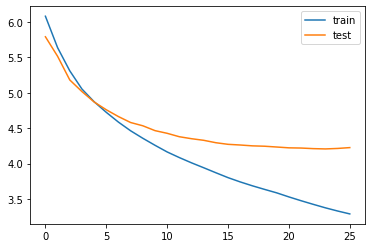

In [29]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [31]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [35]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_length - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [36]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString


In [37]:
for i in range(0,5):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print ('\n')

Review: hearing petition seeking deletion scene netflix series sacred game allegedly defamed late pm rajiv gandhi delhi high court monday observed actor held liable dialogue petition ha alleged series used derogatory language gandhi falsely depicted historical incident like bofors scam shah bano case 
Original summary: actor liable dialogue hc sacred game row 
Predicted summary:  rajiv gandhi used national anthem delhi


Review: congress vice president rahul gandhi said saturday recent attack convoy gujarat wa carried people bjp gandhi said prime minister narendra modi way politics added done people would condemn 
Original summary: bjp people attacked convoy gujarat rahul gandhi 
Predicted summary:  rahul gandhi call pm modi gujarat cm


Review: maker raabta rejected claim film copy telugu film magadheera added extremely disrespectful people belittle someone hard work allege plagiarism basis trailer maker magadheera accused raabta producer copying story approached court seeking injunct

In [40]:

from rouge import Rouge
rouge=Rouge()
rouge1_prec = 0
rouge1_recall = 0
rouge1_f = 0

rouge2_prec = 0
rouge2_recall = 0
rouge2_f = 0
for i in range(0,len(x_tr)):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print ('\n')
    print(i)
    rouge_scores = rouge.get_scores(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    rouge1_prec +=rouge_scores[0].get('rouge-1').get('p')
    rouge1_recall +=rouge_scores[0].get('rouge-1').get('r')
    rouge1_f +=rouge_scores[0].get('rouge-1').get('f')
    
    rouge2_prec +=rouge_scores[0].get('rouge-2').get('p')
    rouge2_recall +=rouge_scores[0].get('rouge-2').get('r')
    rouge2_f +=rouge_scores[0].get('rouge-2').get('f')

Review: hearing petition seeking deletion scene netflix series sacred game allegedly defamed late pm rajiv gandhi delhi high court monday observed actor held liable dialogue petition ha alleged series used derogatory language gandhi falsely depicted historical incident like bofors scam shah bano case 
Original summary: actor liable dialogue hc sacred game row 
Predicted summary:  rajiv gandhi used national anthem delhi


0
Review: congress vice president rahul gandhi said saturday recent attack convoy gujarat wa carried people bjp gandhi said prime minister narendra modi way politics added done people would condemn 
Original summary: bjp people attacked convoy gujarat rahul gandhi 
Predicted summary:  rahul gandhi call pm modi gujarat cm


1
Review: maker raabta rejected claim film copy telugu film magadheera added extremely disrespectful people belittle someone hard work allege plagiarism basis trailer maker magadheera accused raabta producer copying story approached court seeking inj

KeyboardInterrupt: 